<h1 align=center><font size = 5>Credit Card Fraud Detection</font></h1>


## Overview

In this notebook, we will be building a variety of models to test which models are best for Credit Card Fraud detection.

### Dataset
The dataset used in this notebook is provided by Machine Learning Group - ULB through Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Key features include:
Time: Time for each transaction
V1-V28: Anonymized features representing various transaction attributes (e.g., time, location, etc.)
Amount: The transaction amount
Class: Binary label indicating whether the transaction is fraudulent (1) or not (0)

There are no missing values in the dataset

### Algorithms
We will be using the following machine learning models.

* [Logistic regression](#logistic_regression)
* [K Nearest Neighbors (KNN)](#knn)
* [Support Vector Classifier (SVC)](#svc)
* [Isolation Forest](#isolation_forest)
* [Random Forest](#random_forest)
* [XGBoost](#xgboost)

## Table of Contents
* [Imports](#imports)
* [Dataset and Validation](#dataset)
* [Data Analysis](#data_analysis)
* [Visualizing with t-SNE](#tsne)
* [Splitting and Normalizing Data](#normalizing_data)
* [Models](#models)
* [Conclusion](#conclusion)

<a id='imports'></a>
## Imports

In [1]:
# pip install matplotlib
# pip install torch
# pip install torch torchvision
# pip install numpy
# pip install pandas
# pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from datetime import datetime, timedelta
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Set seaborn plot style
sns.set_style("darkgrid")

<a id='dataset'></a>
## Dataset and Validation

In [4]:
# Load the data and feature columns
data = pd.read_csv('creditcard.csv')

# Load the data and define its feature columns.
feat_cols = [i for i in data.columns if i[0] == 'V']
feat_cols.extend(['Amount'])
print('The feature columns are: {}'.format(feat_cols))

# Print shape of the dataset and the head
print('Shape of our Dataset -',data.shape)
data.head()

The feature columns are: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Shape of our Dataset - (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Get info on the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
# Check for missing values
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### Observations

* There are no missing values
* All datatype values look good
* 'Class' is our output feature indicating whether the transaction is fraudulent (1) or not (0)

<a id='data_analysis'></a>
## Data Analysis

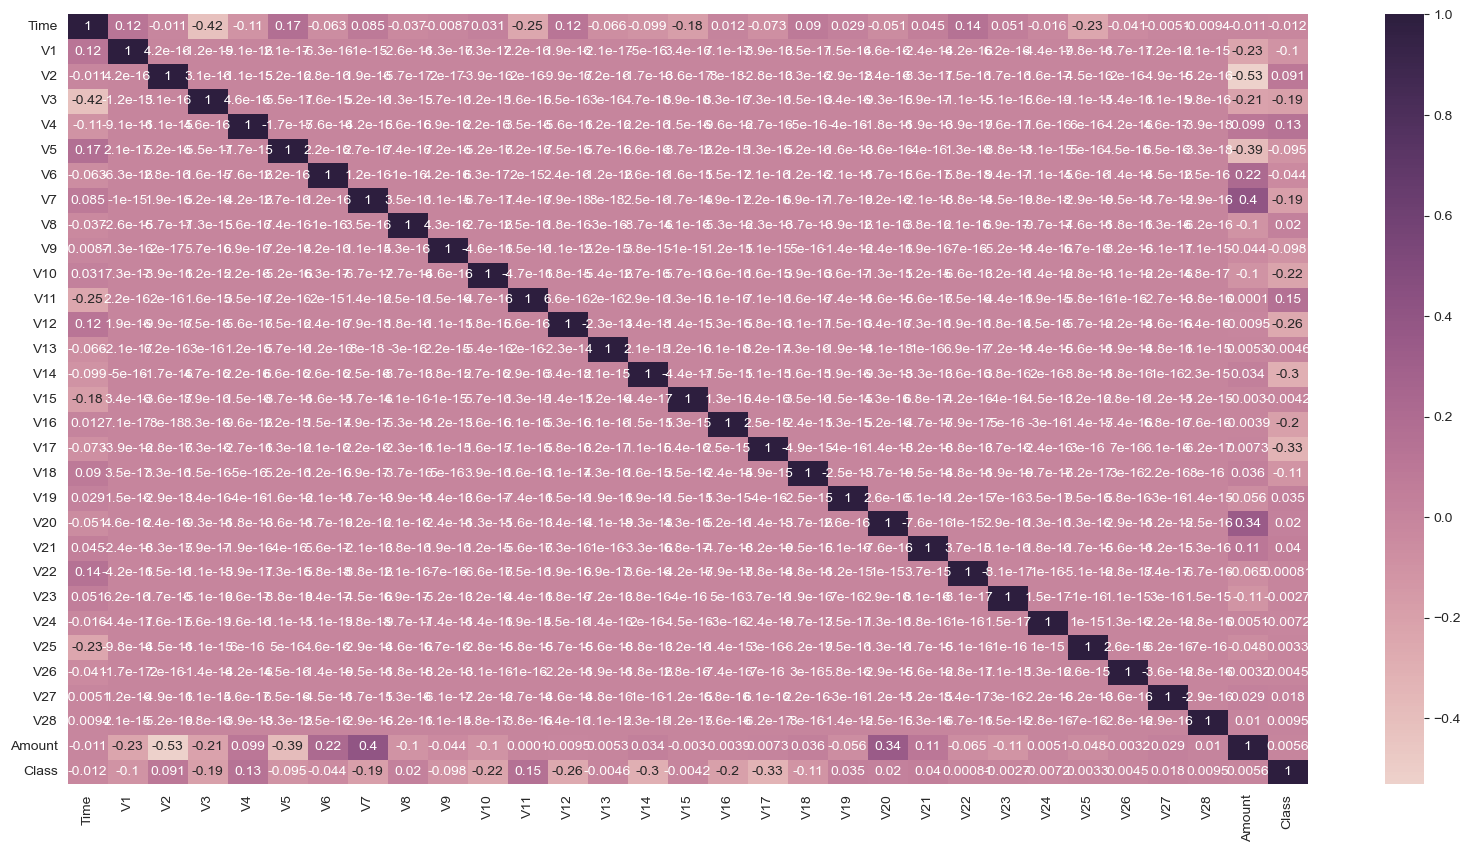

In [8]:
heatmap = plt.figure(figsize=[20,10])
sns.heatmap(data.corr(),cmap=sns.cubehelix_palette(as_cmap=True), annot=True)
plt.show()

#### Observations

* Features V7, V20 are positively correlated to Amount
* Features V1, V2, V5 are negatively correlated to Amount
* Features V3, V7, V10, V12, V14, V16, V17 are negatively correlated to Class

Let's look at the distribution of fraud vs. non fraud.

In [9]:
total = data.shape[0]
fraud = data[data['Class'] == 1]
non_fraud = data[data['Class'] == 0]
contamination = len(fraud)/total

print('frauds :',contamination*100,'%')
print('non frauds :',len(non_fraud)/total*100,'%')
print(len(fraud))
print(len(non_fraud))
print(contamination)

frauds : 0.1727485630620034 %
non frauds : 99.82725143693798 %
492
284315
0.001727485630620034


Let's look at the distribution of the transaction amounts.

<Axes: >

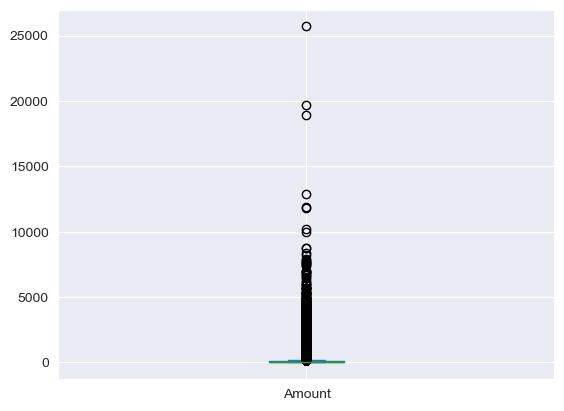

In [10]:
data['Amount'].plot.box()

In [11]:
amountMin = str(data['Amount'].min())
amountMax = str(data['Amount'].max())
amountMed = str(data['Amount'].median())
amountMean = str(data['Amount'].mean())
print(f"Transaction amount Min: " + amountMin)
print(f"Transaction amount Max: " + amountMax)
print(f"Transaction amount Median: " + amountMed)
print(f"Transaction amount Mean: " + amountMean)

Transaction amount Min: 0.0
Transaction amount Max: 25691.16
Transaction amount Median: 22.0
Transaction amount Mean: 88.34961925093133


Let's look at the Transaction Amount distribution

/Users/edwardho/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


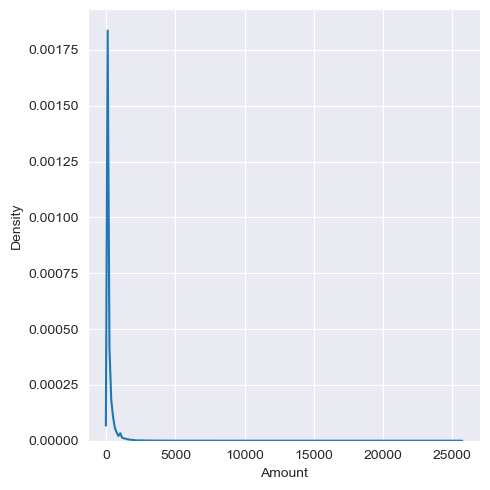

In [12]:
sns.displot(data=data['Amount'], kind="kde", bw_adjust=0.5)
plt.show()

Let's look at distribution regarding time and amount.

<Axes: xlabel='Time', ylabel='Amount'>

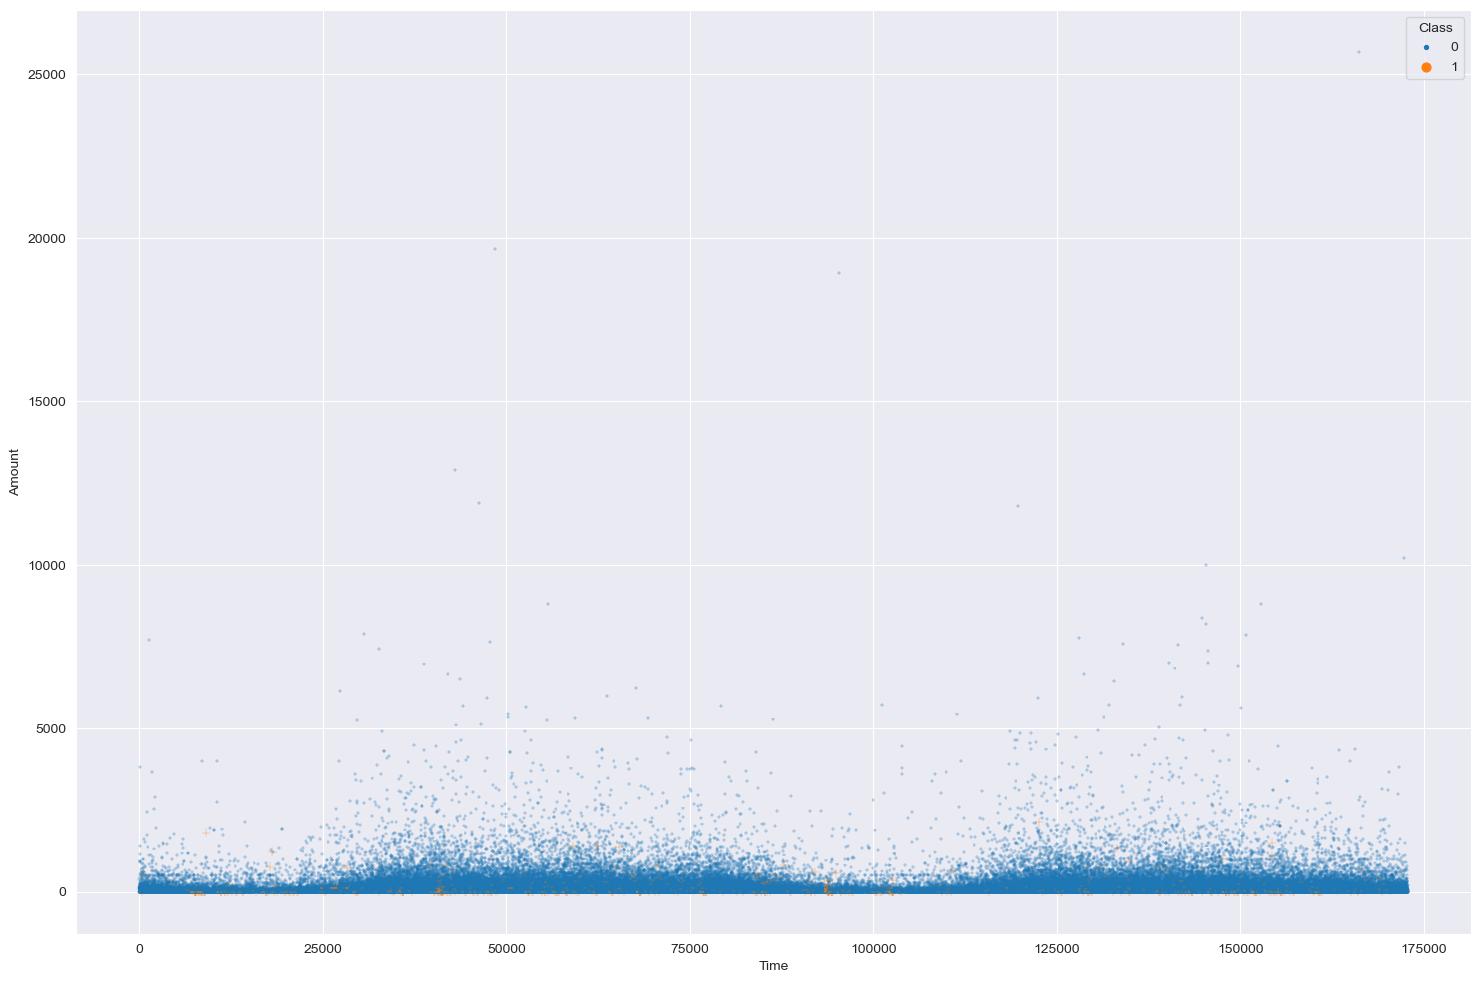

In [13]:
plt.figure(figsize=(18,12))
sns.scatterplot(x=data["Time"], y=data["Amount"], hue=data["Class"], size=data["Class"], sizes=(40, 8), marker="+")

We can also look at the distribution of data regarding time looking at the day and night trend.

/Users/edwardho/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1600x1200 with 0 Axes>

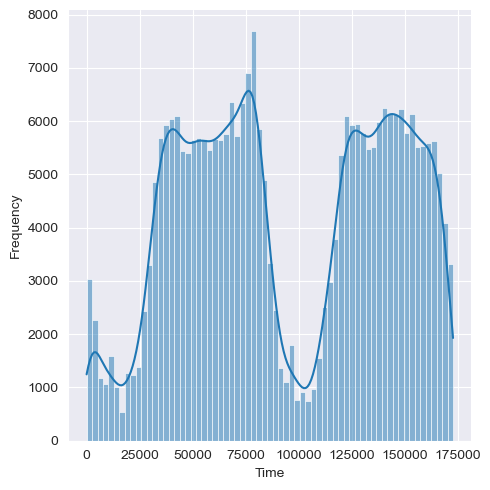

In [14]:
plt.figure(figsize=(16,12))
plot = sns.displot(x=data["Time"], kde=True)
plot.set(xlabel ='Time', ylabel ='Frequency')
plt.show()

/Users/edwardho/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1600x1200 with 0 Axes>

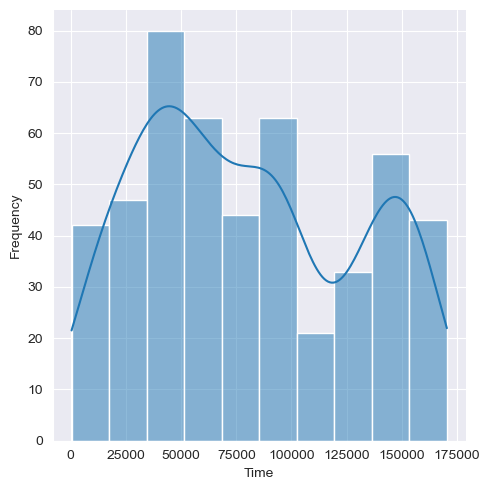

In [15]:
# Fraud Frequency
plt.figure(figsize=(16,12))
plot = sns.displot(x=fraud["Time"], kde=True)
plot.set(xlabel ='Time', ylabel ='Frequency')
plt.show()

/Users/edwardho/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1600x1200 with 0 Axes>

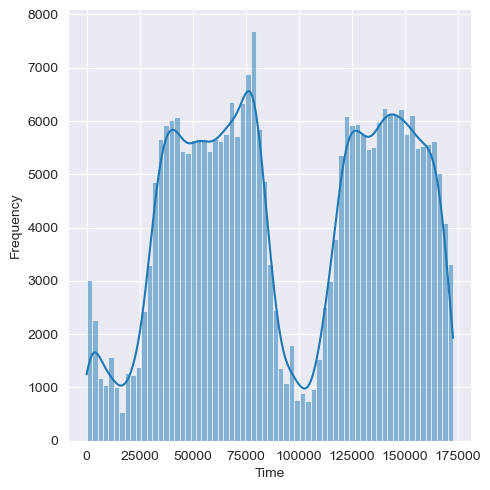

In [16]:
# Non-Fraud Frequency
plt.figure(figsize=(16,12))
plot = sns.displot(x=non_fraud["Time"], kde=True)
plot.set(xlabel ='Time', ylabel ='Frequency')
plt.show()

<Axes: xlabel='Time', ylabel='Density'>

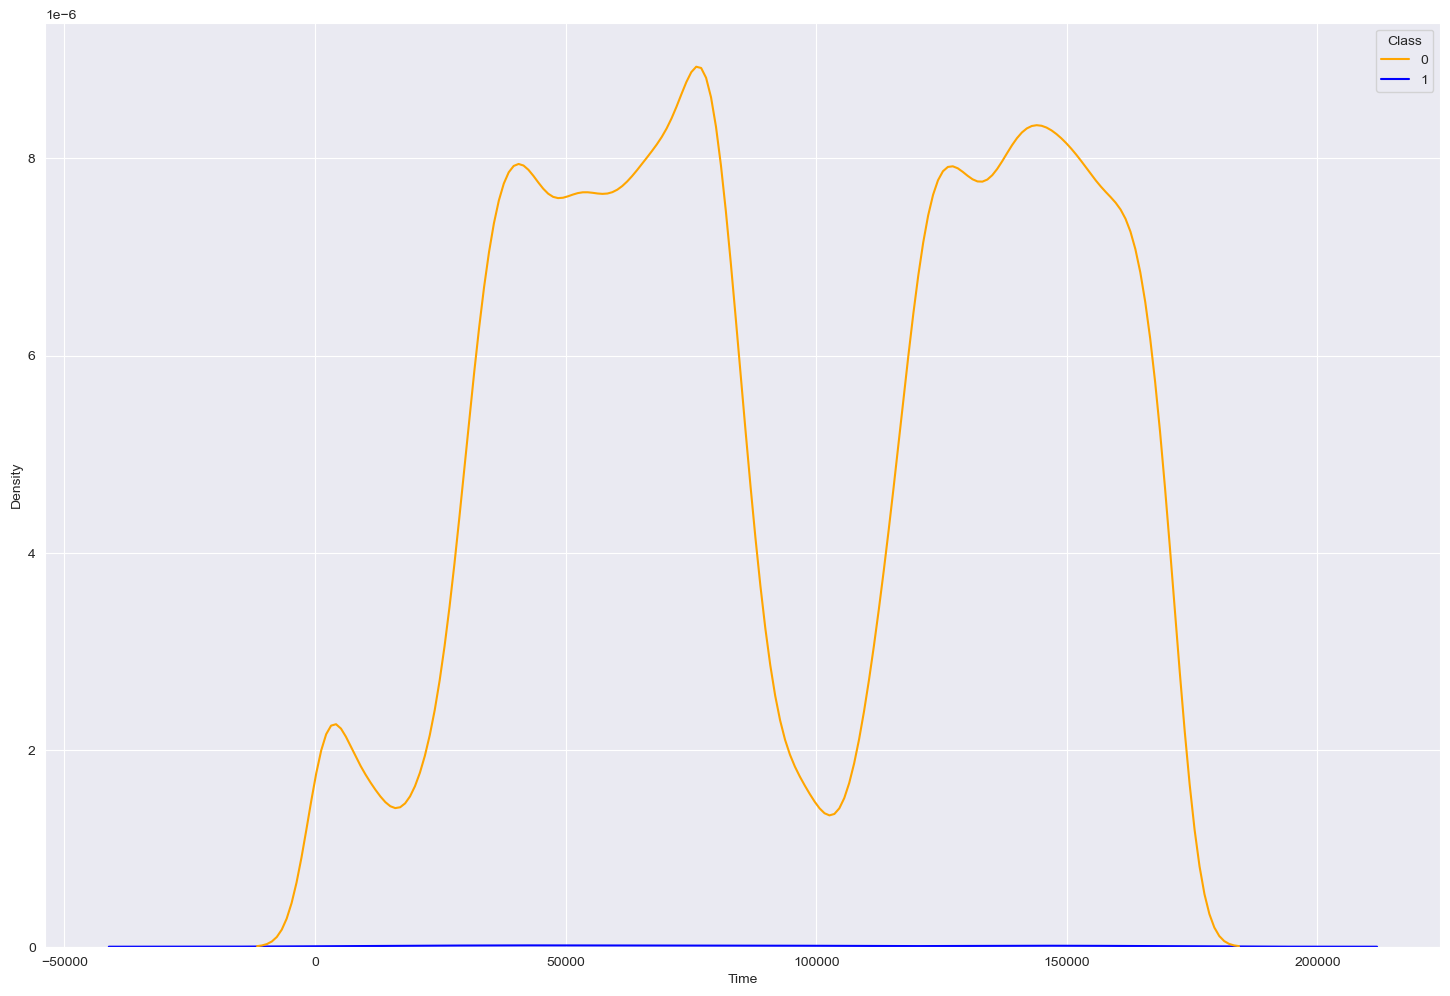

In [17]:
# Density distribution of both
plt.figure(figsize=(18,12))

sns.kdeplot(data=data, x="Time", hue="Class", palette=['orange', 'blue'])

<a id='tsne'></a>
## Visualizing with t-SNE

Here we are randomly sampling 10000 data points for visualization with t-SNE

In [18]:
data_sample = data.sample(n=10000, random_state=361932)
x_sample = data_sample.drop(columns=['Class']).values
y_sample = data_sample['Class'].values
print('Shape of x_sample',x_sample.shape)
print('Shape of y_sample',y_sample.shape)

Shape of x_sample (10000, 30)
Shape of y_sample (10000,)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.280s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 156.414028
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.887783
[t-SNE] KL divergence after 1000 iterations: 0.403113


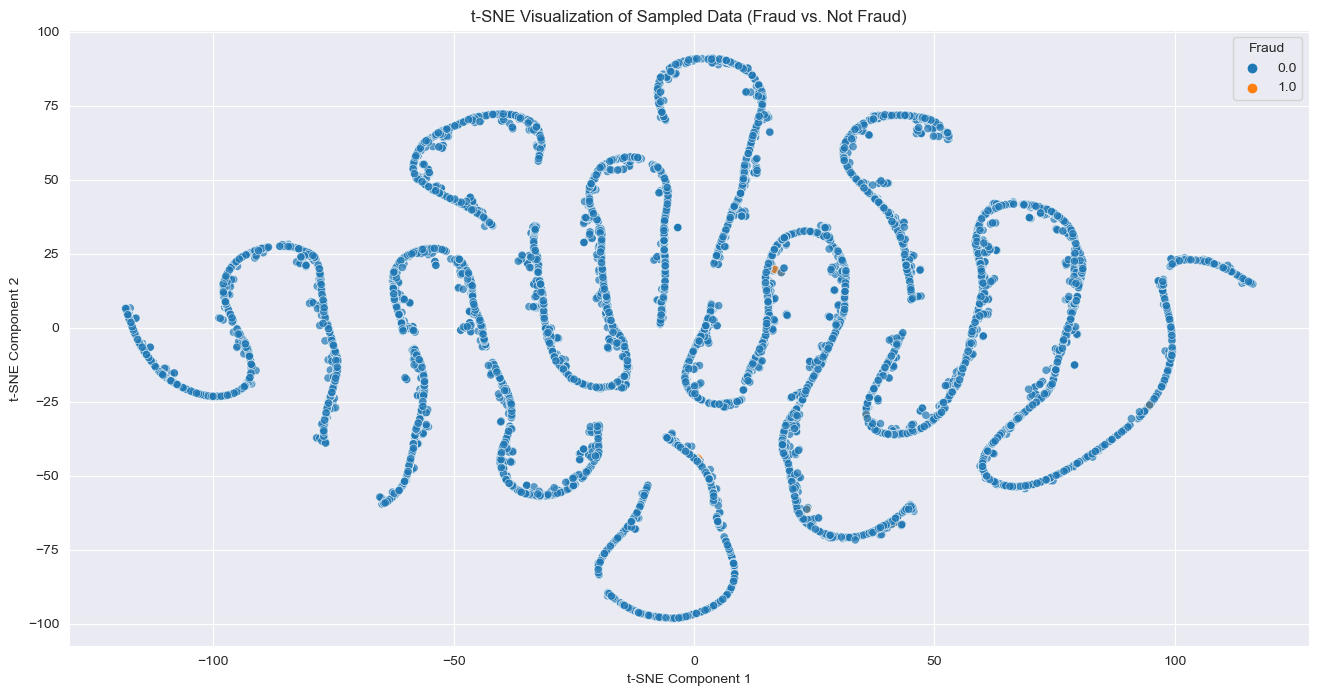

In [19]:
# Create a DataFrame for easy plotting
data_sample = pd.DataFrame(data=np.c_[x_sample, y_sample], columns=[f'Feature_{i}' for i in range(x_sample.shape[1])] + ['Fraud'])

# Perform t-SNE transformation
tsne = TSNE(n_components=2, verbose=1, random_state=42)
X_tsne = tsne.fit_transform(x_sample)

# Add t-SNE components to the DataFrame
data_sample['t-SNE Component 1'] = X_tsne[:, 0]
data_sample['t-SNE Component 2'] = X_tsne[:, 1]

# Plot the t-SNE visualization
plt.figure(figsize=(16, 8))
sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', hue='Fraud', data=data_sample, alpha=0.7)
plt.title('t-SNE Visualization of Sampled Data (Fraud vs. Not Fraud)')
plt.show()

We can see that the fraud vs. non-fraud data is close to linearly separable in our t-SNE visualization.

<a id='normalizing_data'></a>
## Splitting and Normalizing Data

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Let's split our data into classes x and y. We will drop id and Class from x as id is not a relevant parameter for prediction and Class is our output variable.

In [21]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [22]:
x = data.drop(columns=['Class']).values
y = data['Class'].values

y = y.reshape(-1, 1)
y = y.astype(float)

In [23]:
print('Shape of x',x.shape)
print('Shape of y',y.shape)

Shape of x (284807, 30)
Shape of y (284807, 1)


We will now use a standard scaler to normalize the feature set.

In [24]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [25]:
# Convert y to a 1D array
y = y.ravel()

# Split our dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [26]:
# Convert our inputs and labels from numpy arrays to tensors
x_train, x_test = torch.tensor(x_train),torch.tensor(x_test)
y_train, y_test = torch.tensor(y_train),torch.tensor(y_test)

In [27]:
print('Shape of x_train',x_train.shape)
print('Shape of y_train',y_train.shape)
print('Shape of x_test',x_test.shape)
print('Shape of y_test',y_test.shape)

Shape of x_train torch.Size([227845, 30])
Shape of y_train torch.Size([227845])
Shape of x_test torch.Size([56962, 30])
Shape of y_test torch.Size([56962])


In [28]:
print(x_train.dtype)
print(y_train.dtype)
print(x_test.dtype)
print(y_test.dtype)

torch.float64
torch.float64
torch.float64
torch.float64


In [29]:
for i in range(5):
    print(f"x_train[{i}]:", x_train[i])
    print(f"y_train[{i}]:", y_train[i])
    print(f"x_test[{i}]:", x_test[i])
    print(f"y_test[{i}]:", y_test[i])

x_train[0]: tensor([ 1.0221,  0.9981, -0.2306, -0.2078,  0.2332, -0.3690, -0.0647, -0.5076,
         0.0301,  0.9599, -0.0280,  0.6123,  1.6929,  1.2618, -0.2642, -0.3624,
         0.3506, -1.0960,  0.7775,  0.2064, -0.1626,  0.3243,  1.3343,  0.0852,
        -0.4600, -0.0863, -0.4495,  0.1119, -0.1428, -0.3133],
       dtype=torch.float64)
y_train[0]: tensor(0., dtype=torch.float64)
x_test[0]: tensor([ -1.1226,  -8.4375,   5.1989, -12.3000,   6.7136,  -9.9938,  -2.1260,
        -13.5008,   6.2941,  -7.7433, -12.9588,   5.1917, -10.8427,   1.6791,
         -9.7788,   0.3942, -11.2973, -22.6486, -10.0200,   3.8103,  -1.9651,
          1.6211,  -1.5539,  -3.7770,   1.1120,  -2.7120,  -0.9596,  -5.0010,
         -3.1592,   1.1028], dtype=torch.float64)
y_test[0]: tensor(1., dtype=torch.float64)
x_train[1]: tensor([ 0.4708, -0.2047, -0.3797,  1.0258, -1.4251, -0.0781,  0.1263,  0.0145,
        -0.3363,  0.0368,  0.5612, -1.9056, -0.7272,  1.0659, -1.2449,  0.6894,
        -0.1827, -1.9197,

<a id='models'></a>
## Models

We will be using the following machine learning models.

* [Logistic regression](#logistic_regression)
* [K Nearest Neighbors (KNN)](#knn)
* [Support Vector Classifier (SVC)](#svc)
* [Isolation Forest](#isolation_forest)
* [Random Forest](#random_forest)
* [XGBoost](#xgboost)

<a id='logistic_regression'></a>
## Logistic Regression

Logistic Regression is a supervised machine learning algorithm used for binary and multiclass classification problems. The algorithm models the probability that a given input belongs to a particular category.

In [30]:
# Create logistic_regression custom class
class logistic_regression(nn.Module):
    
    # Constructor
    def __init__(self, input_dim, output_dim):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    # Prediction
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

### Training the Classifier

In [31]:
# Hyperparameters
input_dim = 30
output_dim = 1
epochs = 2000
learning_rate = 0.001

# Create logistic regression model
log_reg_model = logistic_regression(input_dim, output_dim)
log_reg_model = log_reg_model.double()

In [32]:
# Print parameters 
print("list(model.parameters()):\n ", list(log_reg_model.parameters()))
print("\nmodel.state_dict():\n ", log_reg_model.state_dict())

list(model.parameters()):
  [Parameter containing:
tensor([[ 0.0159,  0.0292, -0.1197,  0.0641, -0.0120,  0.1097,  0.1146, -0.0397,
         -0.0707, -0.1595, -0.0235, -0.1518, -0.0530, -0.0898, -0.1680, -0.1420,
          0.0693, -0.0023,  0.1075, -0.1017,  0.0049,  0.1115,  0.1583,  0.1566,
         -0.1108,  0.0707, -0.0792, -0.0559, -0.0269,  0.0076]],
       dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-0.0256], dtype=torch.float64, requires_grad=True)]

model.state_dict():
  OrderedDict([('linear.weight', tensor([[ 0.0159,  0.0292, -0.1197,  0.0641, -0.0120,  0.1097,  0.1146, -0.0397,
         -0.0707, -0.1595, -0.0235, -0.1518, -0.0530, -0.0898, -0.1680, -0.1420,
          0.0693, -0.0023,  0.1075, -0.1017,  0.0049,  0.1115,  0.1583,  0.1566,
         -0.1108,  0.0707, -0.0792, -0.0559, -0.0269,  0.0076]],
       dtype=torch.float64)), ('linear.bias', tensor([-0.0256], dtype=torch.float64))])


We will use the SGD optimizer and Cross Entropy Loss as these perform well in classification tasks.

In [33]:
# defining the optimizer
optimizer = torch.optim.SGD(log_reg_model.parameters(), lr=learning_rate)
# defining Cross-Entropy loss
criterion = torch.nn.BCELoss()

In [34]:
# Lists to store loss and accuracy for plotting
lr_train_losses = []
lr_val_losses = []
lr_accuracies = []

# Training loop
for epoch in range(epochs):
    # Training
    y_hat_train = log_reg_model(x_train)
    
    # Reshape y_train
    y_train_reshaped = y_train.view_as(y_hat_train).double()
    
    loss_train = criterion(y_hat_train, y_train_reshaped)
    loss_train.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Validation
    if (epoch + 1) % 100 == 0:
        with torch.no_grad():
            log_reg_model.eval()
            y_hat_test = log_reg_model(x_test)
            
            # Reshape y_test
            y_test_reshaped = y_test.view_as(y_hat_test).double()
            
            loss_val = criterion(y_hat_test, y_test_reshaped)

            # Convert probabilities to class predictions (0 or 1)
            y_hat_test = (y_hat_test >= 0.5).float()

            # Calculate accuracy
            accuracy = accuracy_score(y_test.numpy(), y_hat_test.numpy())

            print('Epoch:', epoch + 1, 'Loss (Train):', loss_train.item(), 'Loss (Validation):', loss_val.item(), 'Accuracy:', accuracy)

            # Store values for plotting
            lr_train_losses.append(loss_train.item())
            lr_val_losses.append(loss_val.item())
            lr_accuracies.append(accuracy)

Epoch: 100 Loss (Train): 0.6873872041099508 Loss (Validation): 0.687571554990761 Accuracy: 0.5742600330044592
Epoch: 200 Loss (Train): 0.6634134212652546 Loss (Validation): 0.6635868072299587 Accuracy: 0.617218496541554
Epoch: 300 Loss (Train): 0.6405522609752751 Loss (Validation): 0.6407156562685303 Accuracy: 0.6569994031108458
Epoch: 400 Loss (Train): 0.6187552142524543 Loss (Validation): 0.6189095141047442 Accuracy: 0.6986763105228047
Epoch: 500 Loss (Train): 0.597974556663679 Loss (Validation): 0.598120580423667 Accuracy: 0.7379305501913557
Epoch: 600 Loss (Train): 0.5781635438254539 Loss (Validation): 0.5783020386074157 Accuracy: 0.7744987886661283
Epoch: 700 Loss (Train): 0.5592765775548144 Loss (Validation): 0.5594082222631451 Accuracy: 0.8081001369333942
Epoch: 800 Loss (Train): 0.5412693436559373 Loss (Validation): 0.5413947532622356 Accuracy: 0.8388048172465854
Epoch: 900 Loss (Train): 0.5240989227941627 Loss (Validation): 0.5242186527570061 Accuracy: 0.8666654962957762
Epoch

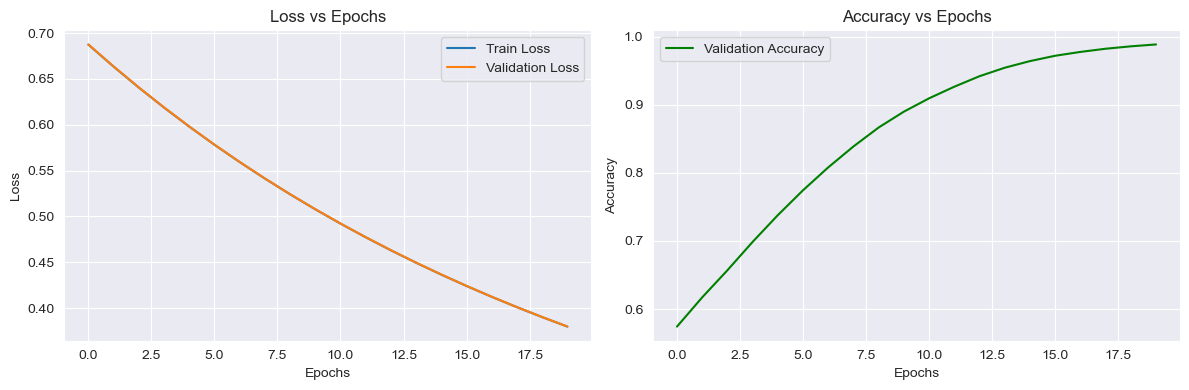

In [35]:
# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(lr_train_losses, label='Train Loss')
plt.plot(lr_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(lr_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

In [36]:
y_test_binary = (np.array(y_test) > 0.5).astype(int)
y_hat_test_binary = (np.array(y_hat_test) > 0.5).astype(int)

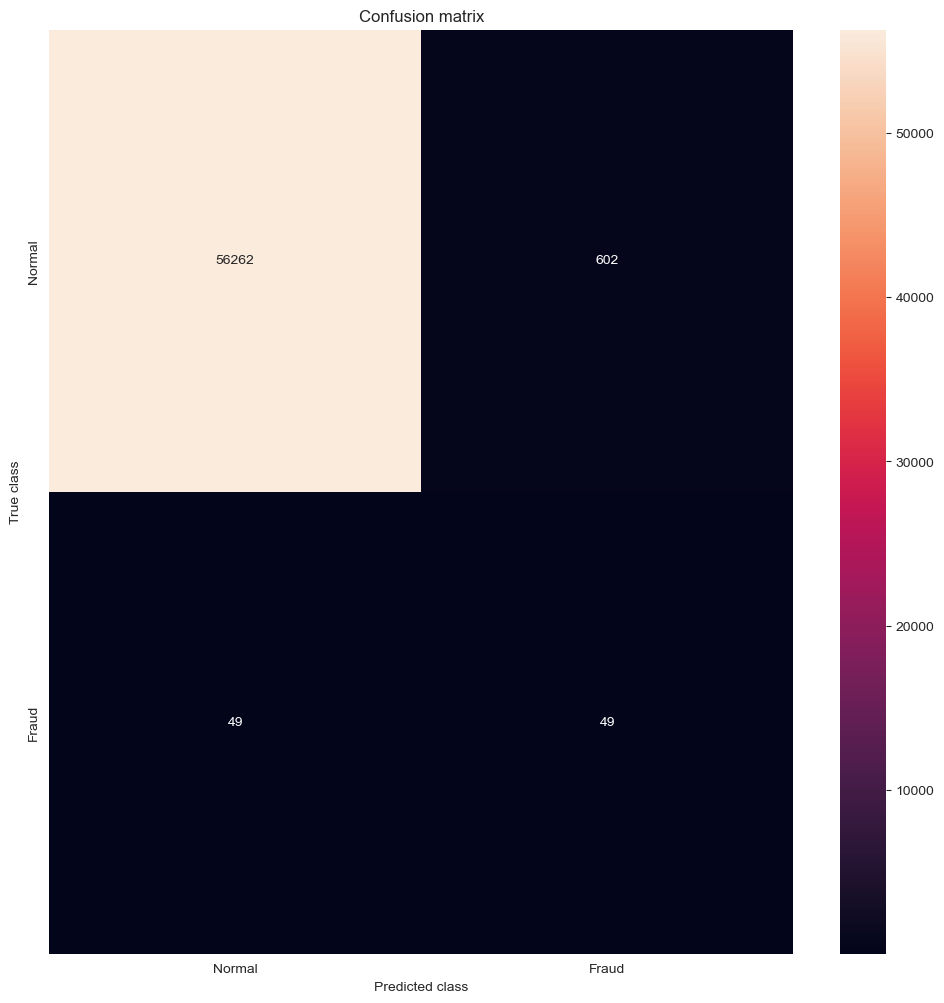

In [37]:
# Printing the confusion matrix
labels = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test_binary, y_hat_test_binary)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=labels,
            yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [38]:
# Classification report
lr_report = classification_report(y_test_binary, y_hat_test_binary)
print('\nClassification Report:\n', lr_report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.08      0.50      0.13        98

    accuracy                           0.99     56962
   macro avg       0.54      0.74      0.56     56962
weighted avg       1.00      0.99      0.99     56962



For logistic regression, we have an accuracy of 98% after 2000 epochs. We have very bad precision near 0 and a bad recall near 0 with an f1-score near 0.

<a id='knn'></a>
## KNN (K Nearest Neighbors)

K-Nearest Neighbors (KNN) is a simple and intuitive supervised machine learning algorithm used for both classification and regression tasks. It's a type of instance-based learning, where the algorithm memorizes the entire training dataset and makes predictions by finding the most similar data points (nearest neighbors) to a new input.

### Cross Validated Gridsearch

We will use scikitlearn for their implementation of KNN as it is difficult to implement algorithms on par to those in scikitlearn in pytorch. We will use cross validated gridsearch to determine the best number of neighbors for KNN on our dataset.

In [39]:
# Choose a range of values for n_neighbors
param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}

# Create KNN classifier
knn = KNeighborsClassifier()

# Use GridSearchCV for cross-validated grid search
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Get the best parameter value
best_n_neighbors = grid_search.best_params_['n_neighbors']

print(f"Best number of neighbors: {best_n_neighbors}")

Best number of neighbors: 3


With an output of 3, we can see what the accuracy of our model is and our classification scores.

### Training the Classifier

In [40]:
# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model
knn.fit(x_train, y_train)

# Make predictions on the test set
y_hat_test = knn.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_hat_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [41]:
y_test_binary = (np.array(y_test) > 0.5).astype(int)
y_hat_test_binary = (np.array(y_hat_test) > 0.5).astype(int)

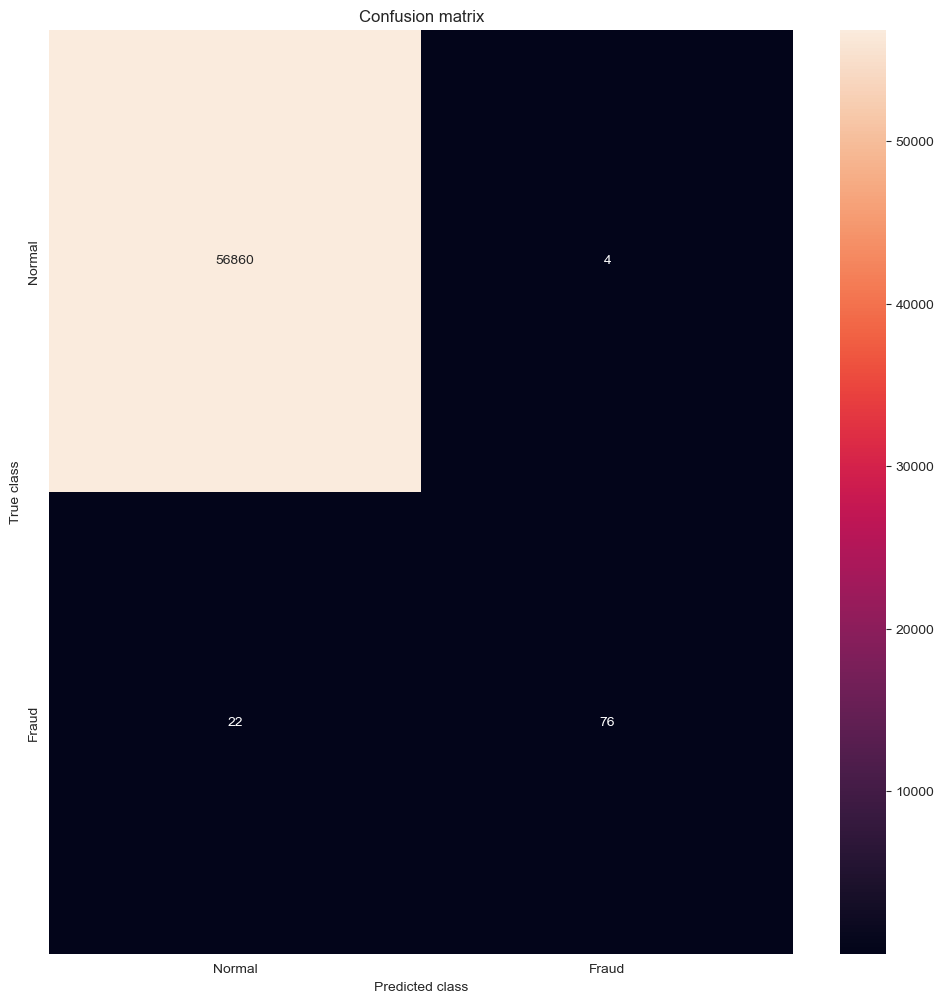

In [42]:
# Printing the confusion matrix
labels = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test_binary, y_hat_test_binary)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=labels,
            yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [43]:
# Classification report
knn_report = classification_report(y_test_binary, y_hat_test_binary)
print('\nClassification Report:\n', knn_report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.78      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



We can see KNN does very well on detecting fraud here with 100% accuracy. We have very good precision of 0.95 and a good recall of 0.78 with an f1-score of 0.85.

<a id='svc'></a>
## Support Vector Classifier (SVC)

A Support Vector Classifier (SVC), also known as a Support Vector Machine (SVM) in the context of binary classification, is a supervised machine learning algorithm that aims to find a hyperplane in a high-dimensional space that best separates the data points of different classes. The "support vectors" are the data points that lie closest to the decision boundary (the hyperplane) and play a crucial role in defining its position.

In [44]:
# Define the Support Vector Classifier model
class SVC(nn.Module):
    def __init__(self):
        super(SVC, self).__init__()
        self.linear = nn.Linear(in_features=x_train.shape[1], out_features=1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

### Training the Classifier

In [45]:
# Hyperparameters
epochs = 2000
learning_rate = 0.001

# Instantiate the model, loss function, and optimizer
svc_model = SVC()
svc_model = svc_model.double()

In [46]:
# Print parameters 
print("list(model.parameters()):\n ", list(svc_model.parameters()))
print("\nmodel.state_dict():\n ", svc_model.state_dict())

list(model.parameters()):
  [Parameter containing:
tensor([[-0.1054,  0.1278,  0.0082, -0.0646,  0.1309, -0.0877, -0.1041,  0.1359,
         -0.0956,  0.1426, -0.1770, -0.0588,  0.1518, -0.0071, -0.0284, -0.1616,
          0.0191, -0.0597, -0.0719,  0.0329, -0.0257, -0.1229, -0.1778,  0.1277,
         -0.0267,  0.0228, -0.1608, -0.1576,  0.1266, -0.0899]],
       dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([0.0830], dtype=torch.float64, requires_grad=True)]

model.state_dict():
  OrderedDict([('linear.weight', tensor([[-0.1054,  0.1278,  0.0082, -0.0646,  0.1309, -0.0877, -0.1041,  0.1359,
         -0.0956,  0.1426, -0.1770, -0.0588,  0.1518, -0.0071, -0.0284, -0.1616,
          0.0191, -0.0597, -0.0719,  0.0329, -0.0257, -0.1229, -0.1778,  0.1277,
         -0.0267,  0.0228, -0.1608, -0.1576,  0.1266, -0.0899]],
       dtype=torch.float64)), ('linear.bias', tensor([0.0830], dtype=torch.float64))])


We will use the SGD optimizer and Cross Entropy Loss as these perform well in classification tasks.

In [47]:
# defining the optimizer
optimizer = optim.SGD(svc_model.parameters(), lr=learning_rate)
# defining Cross-Entropy loss
criterion = torch.nn.BCELoss()

In [48]:
# Lists to store loss and accuracy for plotting
svc_train_losses = []
svc_val_losses = []
svc_accuracies = []

for epoch in range(epochs):
    # Forward pass
    outputs = svc_model(x_train)
    loss = criterion(outputs, y_train.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    if (epoch + 1) % 100 == 0:
        with torch.no_grad():
            svc_model.eval()
            y_hat_test = svc_model(x_test)
            
            # Reshape y_test
            y_test_reshaped = y_test.view_as(y_hat_test).double()
            
            loss_val = criterion(y_hat_test, y_test_reshaped)

            # Convert probabilities to class predictions (0 or 1)
            y_hat_test = (y_hat_test >= 0.5).float()

            # Calculate accuracy
            accuracy = accuracy_score(y_test.numpy(), y_hat_test.numpy())

            print('Epoch:', epoch + 1, 'Loss (Train):', loss_train.item(), 'Loss (Validation):', loss_val.item(), 'Accuracy:', accuracy)

            # Store values for plotting
            svc_train_losses.append(loss_train.item())
            svc_val_losses.append(loss_val.item())
            svc_accuracies.append(accuracy)

Epoch: 100 Loss (Train): 0.3797318918136269 Loss (Validation): 0.7437586757663552 Accuracy: 0.4449281977458657
Epoch: 200 Loss (Train): 0.3797318918136269 Loss (Validation): 0.7171672868488297 Accuracy: 0.4816544362908606
Epoch: 300 Loss (Train): 0.3797318918136269 Loss (Validation): 0.6917990195498029 Accuracy: 0.5229451213089428
Epoch: 400 Loss (Train): 0.3797318918136269 Loss (Validation): 0.6676043656854261 Accuracy: 0.5649731399880622
Epoch: 500 Loss (Train): 0.3797318918136269 Loss (Validation): 0.644534014946746 Accuracy: 0.6092131596502932
Epoch: 600 Loss (Train): 0.3797318918136269 Loss (Validation): 0.6225391298637124 Accuracy: 0.6528914012850673
Epoch: 700 Loss (Train): 0.3797318918136269 Loss (Validation): 0.6015715898619879 Accuracy: 0.6960956427091746
Epoch: 800 Loss (Train): 0.3797318918136269 Loss (Validation): 0.5815842038461624 Accuracy: 0.7401074400477511
Epoch: 900 Loss (Train): 0.3797318918136269 Loss (Validation): 0.5625308915487566 Accuracy: 0.7808363470383765
Ep

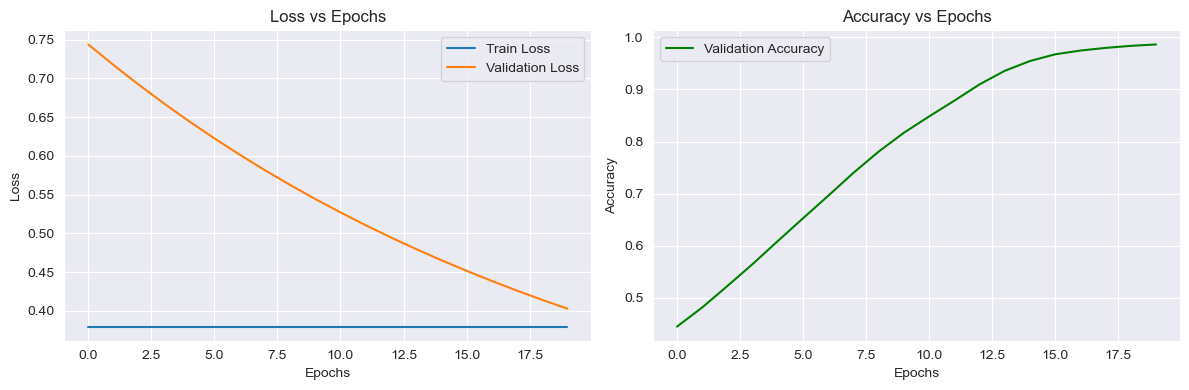

In [49]:
# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(svc_train_losses, label='Train Loss')
plt.plot(svc_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(svc_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.tight_layout()
plt.show()

In [50]:
y_test_binary = (np.array(y_test) > 0.5).astype(int)
y_hat_test_binary = (np.array(y_hat_test) > 0.5).astype(int)

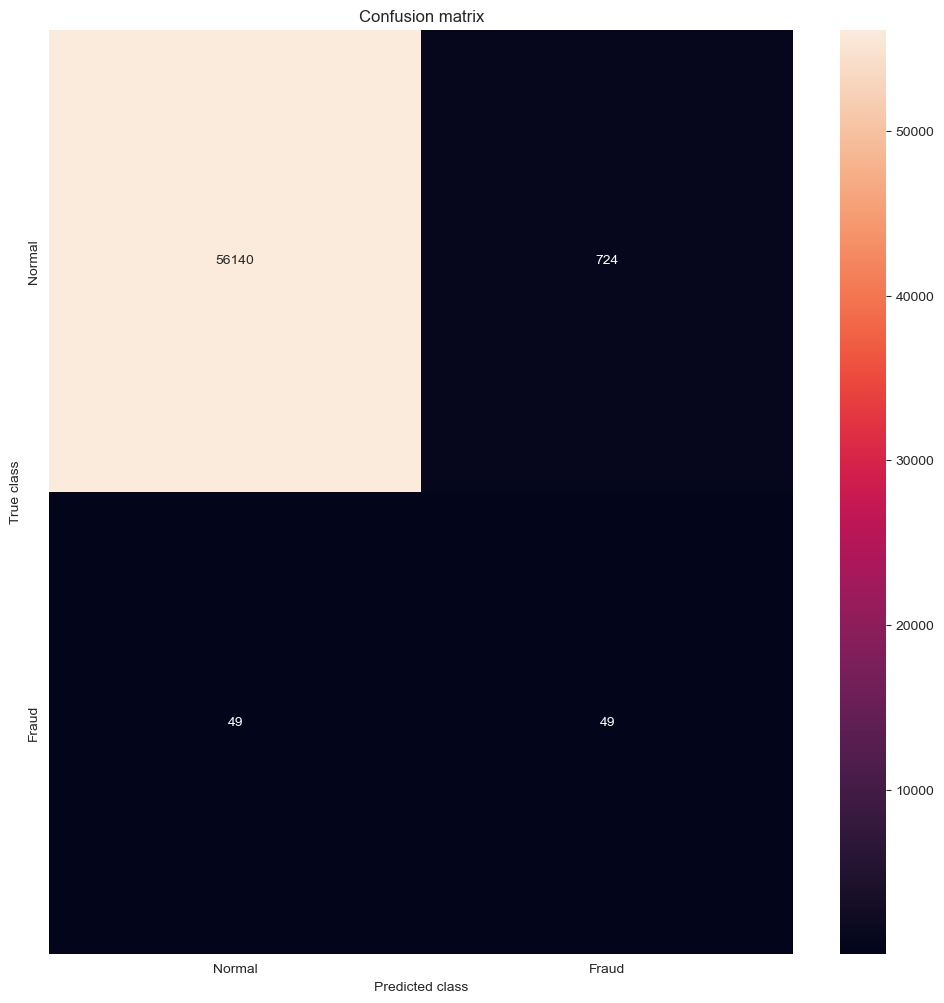

In [51]:
# Printing the confusion matrix
labels = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test_binary, y_hat_test_binary)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=labels,
            yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [52]:
# Classification report
svc_report = classification_report(y_test_binary, y_hat_test_binary)
print('\nClassification Report:\n', svc_report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.06      0.50      0.11        98

    accuracy                           0.99     56962
   macro avg       0.53      0.74      0.55     56962
weighted avg       1.00      0.99      0.99     56962



For SVC, we have about 99% accuracy rate after 2000 epochs. We have very low precision near 0, a low recall near 0 ,and an f1-score near 0.

<a id='isolation_forest'></a>
## Isolation Forest

The Isolation Forest algorithm is an unsupervised machine learning algorithm used for anomaly detection. We will use the scikit learn classifier.

### Training the Classifier

In [53]:
# Initialize the Isolation Forest classifier
ifc_model=IsolationForest(max_samples=len(x_train), contamination=contamination, random_state=1)

# Train the model
ifc_model.fit(x_train, y_train)
scores_pred = ifc_model.decision_function(x_train)

# Make predictions on the test set
y_hat_test = ifc_model.predict(x_test)

# Reshape the prediction values to 0 for valid, 1 for fraud. 
y_hat_test[y_hat_test == 1] = 0
y_hat_test[y_hat_test == -1] = 1

# Evaluate the model
accuracy = accuracy_score(y_test, y_hat_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [54]:
y_test_binary = (np.array(y_test) > 0.5).astype(int)
y_hat_test_binary = (np.array(y_hat_test) > 0.5).astype(int)

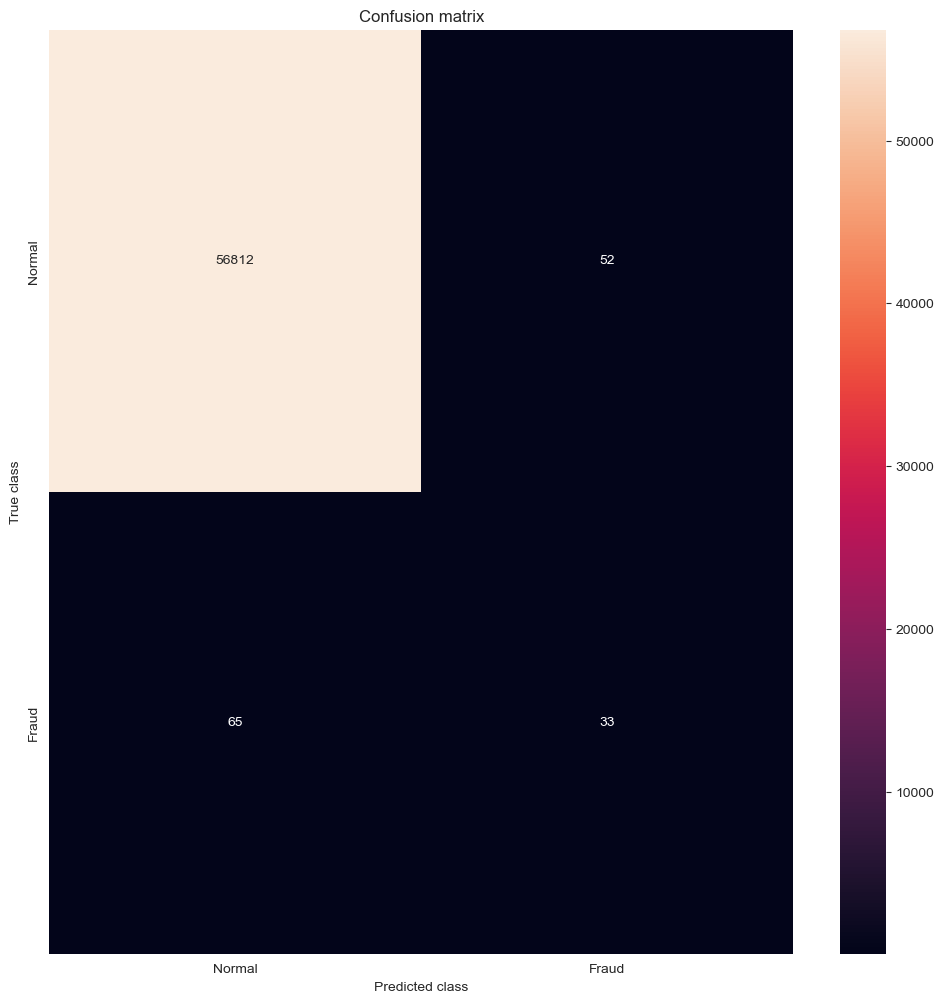

In [55]:
# Printing the confusion matrix
labels = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test_binary, y_hat_test_binary)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=labels,
            yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [56]:
# Classification report
if_report = classification_report(y_test_binary, y_hat_test_binary)
print('\nClassification Report:\n', if_report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.39      0.34      0.36        98

    accuracy                           1.00     56962
   macro avg       0.69      0.67      0.68     56962
weighted avg       1.00      1.00      1.00     56962



For Isolation Forest we have 100% accuracy but low precision of 0.39 and low recall of 0.34 with an f1-score of 0.36.

<a id='random_forest'></a>
## Random Forest

Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. We will be using the scikit learn library for this as implementing it by hand from decision trees is a very involved process.

### Training the Classifier

In [57]:
# Initialize the Random Forest classifier
rfc_model = RandomForestClassifier()

# Train the model
rfc_model.fit(x_train, y_train)

# Make predictions on the test set
y_hat_test = rfc_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_hat_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [58]:
y_test_binary = (np.array(y_test) > 0.5).astype(int)
y_hat_test_binary = (np.array(y_hat_test) > 0.5).astype(int)

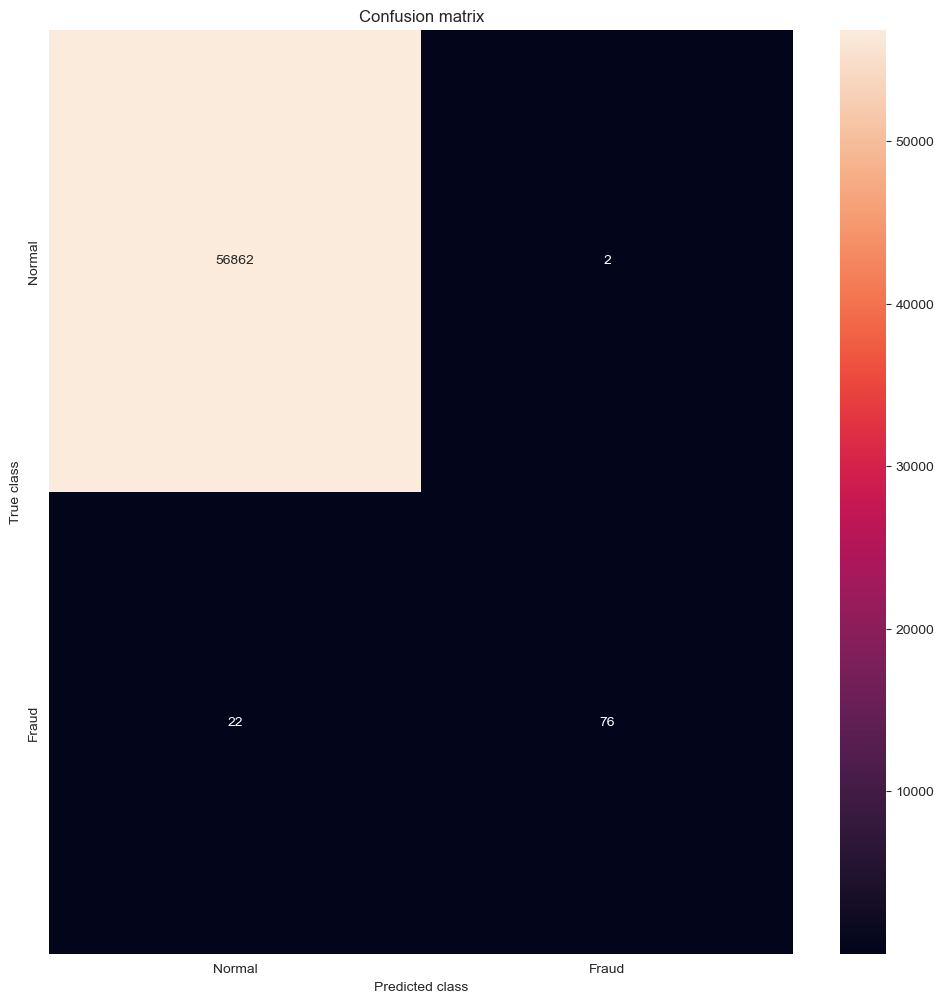

In [59]:
# Printing the confusion matrix
labels = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test_binary, y_hat_test_binary)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=labels,
            yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [60]:
# Classification report
rf_report = classification_report(y_test_binary, y_hat_test_binary)
print('\nClassification Report:\n', rf_report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



For Random Forest we have 100% accuracy and a high precision of 0.97, a good recall of 0.78, and an f1-score of 0.86.

<a id='xgboost'></a>
## XGBoost

Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. We will be using the scikit learn library for this as implementing it by hand from decision trees is a very involved process.

### Training the Classifier

In [61]:
# Initialize the Random Forest classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Specify the learning task and objective
    eval_metric='logloss',  # Evaluation metric for training
    seed=42  # Seed for reproducibility
)

# Train the model
xgb_model.fit(x_train, y_train)

# Make predictions on the test set
y_hat_test = xgb_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_hat_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [62]:
y_test_binary = (np.array(y_test) > 0.5).astype(int)
y_hat_test_binary = (np.array(y_hat_test) > 0.5).astype(int)

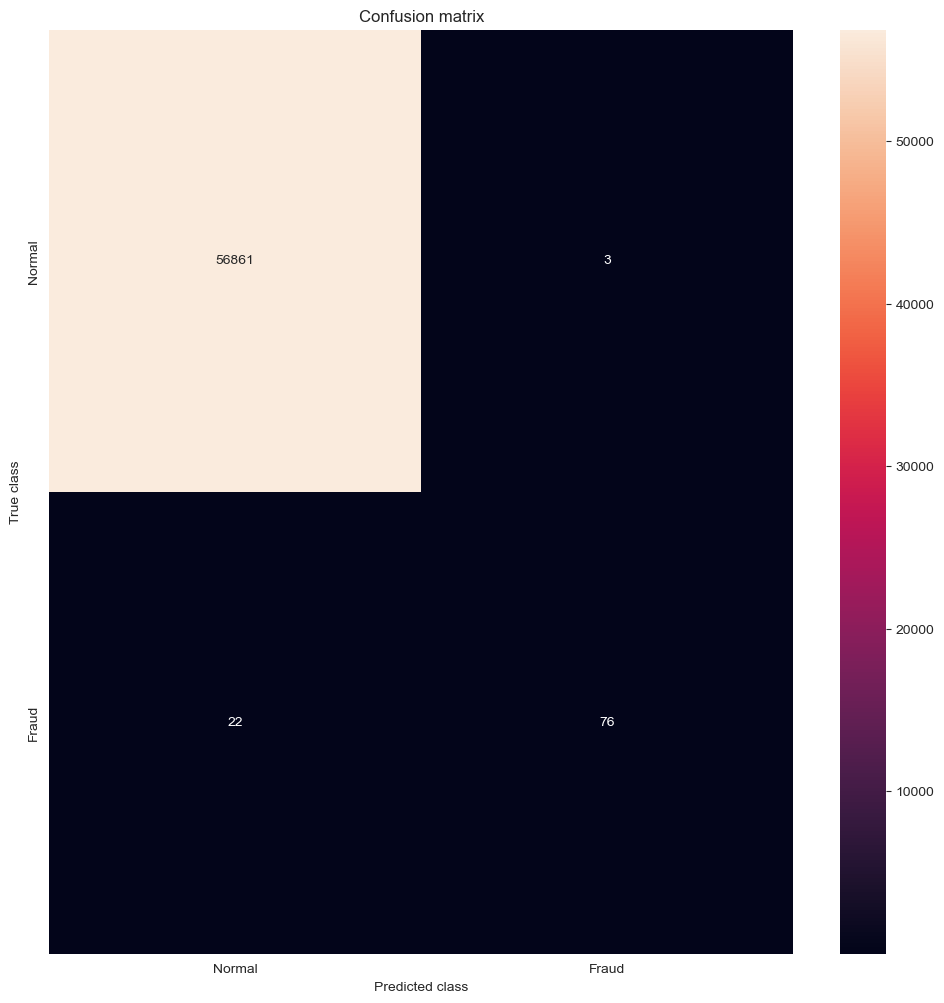

In [63]:
# Printing the confusion matrix
labels = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test_binary, y_hat_test_binary)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=labels,
            yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [64]:
# Classification report
xgb_report = classification_report(y_test_binary, y_hat_test_binary)
print('\nClassification Report:\n', xgb_report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



For XGBoost we have 100% accuracy and a high precision of 0.96, a good recall of 0.78, and an f1-score of 0.86.

<a id='conclusion'></a>
## Conclusion

Here we are looking at all the following classification reports to compare all of our models here:

* [Logistic regression](#logistic_regression)
* [K Nearest Neighbors (KNN)](#knn)
* [Support Vector Classifier (SVC)](#svc)
* [Isolation Forest](#isolation_forest)
* [Random Forest](#random_forest)
* [XGBoost](#xgboost)

In [65]:
print('\nLogistic regression Classification Report:\n', lr_report)
print('\nK Nearest Neighbors (KNN) Classification Report:\n', knn_report)
print('\nSupport Vector Classifier (SVC) Classification Report:\n', svc_report)
print('\nIsolation Forest Classification Report:\n', if_report)
print('\nRandom Forest Classification Report:\n', rf_report)
print('\nXGBoost Classification Report:\n', xgb_report)


Logistic regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.08      0.50      0.13        98

    accuracy                           0.99     56962
   macro avg       0.54      0.74      0.56     56962
weighted avg       1.00      0.99      0.99     56962


K Nearest Neighbors (KNN) Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.78      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962


Support Vector Classifier (SVC) Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.06      0.50      0.11        98

    accuracy                 

Let's analyze the classification reports for each model:

### Model Scores

#### Logistic Regression:
* Precision (Class 1): 0.08
* Recall (Class 1): 0.84
* F1-Score (Class 1): 0.15
* Accuracy: 0.98

#### K Nearest Neighbors (KNN):
* Precision (Class 1): 0.95
* Recall (Class 1): 0.78
* F1-Score (Class 1): 0.85
* Accuracy: 1.00

#### Support Vector Classifier (SVC):
* Precision (Class 1): 0.08
* Recall (Class 1): 0.66
* F1-Score (Class 1): 0.14
* Accuracy: 0.99

#### Isolation Forest:
* Precision (Class 1): 0.39
* Recall (Class 1): 0.34
* F1-Score (Class 1): 0.36
* Accuracy: 1.00

#### Random Forest:
* Precision (Class 1): 0.99
* Recall (Class 1): 0.78
* F1-Score (Class 1): 0.87
* Accuracy: 1.00

#### XGBoost:
* Precision (Class 1): 0.96
* Recall (Class 1): 0.78
* F1-Score (Class 1): 0.86
* Accuracy: 1.00

### Analysis
* Accuracy: All models have high accuracy, but accuracy alone is not the best metric for imbalanced datasets.
* Precision, Recall, F1-Score (Class 1): The models differ in their ability to correctly classify the minority class (Class 1), which is critical in fraud detection or similar scenarios.

K Nearest Neighbors (KNN) performs well overall, with high precision, recall, and F1-score for Class 1.
Random Forest also performs well with high precision, recall, and F1-score for Class 1.
XGBoost shows a good balance between precision, recall, and F1-score for Class 1.

Out of all of these models, I would likely select XGBoost out of these for its performance on runtime as well as it's ability to classify fraudulent transactions in such an unbalanced data set.